In [1]:
import torch
import torchvision.transforms as tt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split


At first we download the FashionMNIST-dataset and convert it to Pytroch-Tensors.
The FashionMNIST-dataset consists of 60000 images in the train-set and 10000 images in the test-set.

Many Datasets like CIFAR or FashionMNIST can be downloaded via torchvision. 
A list of all datasets avaiable with torchvision can be obtained here: https://pytorch.org/docs/stable/torchvision/datasets.html
Other custome datasets have to be created form csv-files or other data-sources.  

with the torchvision transforms module the data ca be augmented in various ways, like for example random crop or colourjitter. 
Data-augmentation can increase the accuracy of the classification significantly. 
For this experiment i refrain from all this methods, because it increases the computation needed for convergence. 


In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True, transform=tt.Compose([tt.ToTensor()]))           
                         
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                              tt.Compose([tt.ToTensor()])) 

print('Images in train-dataset: {}\nImages in test-dataset: {}'.format(len(train_set), len(test_set)))

Images in train-dataset: 60000
Images in test-dataset: 10000


The test-dataset and the train-dataset are now converted to Pytorch-DataLoader objects.
Pytorch-DataLoaders are Iterators, which shuffel the dataset and iterate over the data in batches of a discrete batch-size.

In [3]:
batch_size = 1000

train_loader = DataLoader(train_set, batch_size, shuffle=True, pin_memory=True)                     
test_loader = DataLoader(test_set, batch_size, shuffle=True, pin_memory=True)

The FashionMNIST-Dataset (created by Zalando) is a collection of different examples of 10 fashion types.

To take a look at some examples of the dataset we will use matplotlib. 

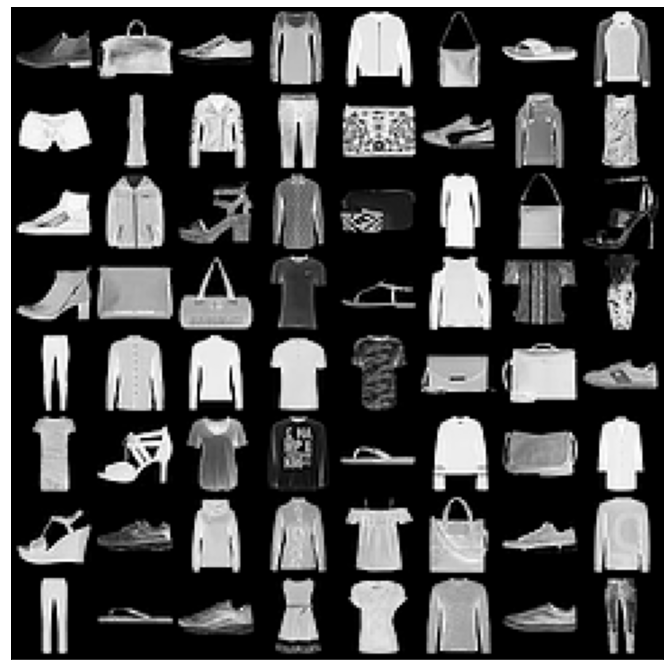

In [4]:
import matplotlib.pyplot as plt


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_loader)

Now we create a simple convolutional neuronal network as a classifier. 

The cnn consists of 3 convolutional layers and one linear layer.

The 3 convolutional layers have 12, 36, and 64 out-channels.

In [5]:
class FashionMNIST_classifier(torch.nn.Module):
    def __init__(self):
        # the following five parameters will be updated, when we train the network.
        
        self.min_loss = 3.4028237 * 10**38                              
        self.max_acc = 0.                        
        self.name = 'FashionMNIST_cnn_no_data_augmentation'
        self.epoch = 0
        self.history = []
        
        super().__init__()
        self.drop = torch.nn.Dropout(0.2)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2)
        
        self.conv_1 = torch.nn.Conv2d(1, 12, 5, padding=(2, 2))
        self.conv_2 = torch.nn.Conv2d(12, 36, 5, padding=(2, 2))
        self.conv_3 = torch.nn.Conv2d(36, 64, 5, padding=(2, 2))
        self.lin_out = torch.nn.Linear(49*64, 10)
        
    def forward(self, images):
        
        # layer1
        out = self.drop(images)
        out = self.conv_1(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # layer2
        out = self.drop(out)
        out = self.conv_2(out)
        out = self.relu(out)
        out = self.pool(out)
        
        # layer3
        out = self.drop(out)
        out = self.conv_3(out)
        out = self.relu(out)
        
        # output_layer
        out = torch.flatten(out, start_dim=1)
        out = self.lin_out(out)
        return out
        
        
model = FashionMNIST_classifier()

To benchmark the performance of the model, a function is defined that returns the accuracy of the predictions

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    right_preds = torch.sum(preds == labels)
    acc = right_preds * (100 / len(labels))
    return acc
    

A function is defined that evaluates the performance of the model at the test_set.
This function will be called once for each epoch

In [7]:
def test_epoch(model, test_loader):
    with torch.no_grad():
        model.eval()
        losses = []
        accuracies = []
        for images, labels in test_loader:
            outputs = model(images)
            accuracies.append(accuracy(outputs, labels))
            losses.append(torch.nn.functional.cross_entropy(outputs, labels))
            
        batch_accuracy = torch.stack(accuracies).mean()
        batch_loss = torch.stack(losses).mean()
            
        return {'batch_accuracy': batch_accuracy.item(), 'batch_loss': batch_loss.item()}
        

The train_epoch function is used to train the model with the data from the train_loader for one epoch.

In [8]:
def train_epoch(model, train_loader, optimizer):
    for images, labels in train_loader:
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

The save function will save the model if a new best value for accuracy or loss is reached.

In [9]:
def save(model, results):
    if results['batch_accuracy'] > model.max_acc or results['batch_loss'] > model.min_loss:
        torch.save(model, r'E:\KI-Models\FashionMNIST_cnn_no_augmentation\ epoch={} loss={} accuracy={}'.format(model.epoch, results['batch_loss'], results['batch_accuracy']))
        
        if results['batch_accuracy'] > model.max_acc:
            model.max_acc = results['batch_accuracy']
        if results['batch_loss'] > model.min_loss:
            model.min_loss = results['batch_loss']
            

The train_loop function will train the model for a given number of epochs and save the model if a new best value for accuracy or loss is reached.

In [10]:
import time


def train_loop(epochs, model=model, train_loader=train_loader, test_loader=test_loader, learning_rate=0.1):
    
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    
    for _ in range(epochs):
        start_time = time.time()
        results = test_epoch(model, test_loader)
        model.history.append([results['batch_accuracy'], results['batch_loss']])
        save(model, results)
        train_epoch(model, train_loader, optimizer)
        model.epoch += 1      
        
        print('''-------------------------------------------------
            epoch: {}
            loss: {:.8f}
            accuracy: {:.2f}%
            duration: {:.2f}s'''.format(
            model.epoch,
            results['batch_loss'], 
            results['batch_accuracy'], 
            time.time() - start_time
            ))
    

In the following we will create a to device function, which sends all tensors to the given device (cuda or cpu).
The DeviceDataloader class creates a dataloader object on the gpu, from an existing dataloader object

In [11]:
def to_device(data):   
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    if isinstance(data, (list,tuple)):
        return [to_device(x) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():                                             
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
    def __iter__(self):
        for b in self.dataloader: 
            yield to_device(b)

    def __len__(self):
        return len(self.dataloader)
    
model = to_device(model)
train_loader = DeviceDataLoader(train_loader)
test_loader = DeviceDataLoader(test_loader)

now we will train the model for 250 epochs.

In [12]:
train_loop(250, model, train_loader, test_loader, 0.05)

-------------------------------------------------
            epoch: 1
            loss: 2.30213141
            accuracy: 10.00%
            duration: 14.34s
-------------------------------------------------
            epoch: 2
            loss: 1.29213750
            accuracy: 63.49%
            duration: 12.79s
-------------------------------------------------
            epoch: 3
            loss: 0.80428189
            accuracy: 68.69%
            duration: 12.83s
-------------------------------------------------
            epoch: 4
            loss: 0.68114054
            accuracy: 75.01%
            duration: 12.93s
-------------------------------------------------
            epoch: 5
            loss: 0.67363042
            accuracy: 75.05%
            duration: 12.85s
-------------------------------------------------
            epoch: 6
            loss: 0.61278009
            accuracy: 77.37%
            duration: 12.95s
-------------------------------------------------
  

-------------------------------------------------
            epoch: 53
            loss: 0.32975385
            accuracy: 88.29%
            duration: 13.12s
-------------------------------------------------
            epoch: 54
            loss: 0.32210645
            accuracy: 88.62%
            duration: 13.31s
-------------------------------------------------
            epoch: 55
            loss: 0.32962614
            accuracy: 88.00%
            duration: 13.15s
-------------------------------------------------
            epoch: 56
            loss: 0.31509665
            accuracy: 88.75%
            duration: 12.98s
-------------------------------------------------
            epoch: 57
            loss: 0.33962676
            accuracy: 87.42%
            duration: 12.91s
-------------------------------------------------
            epoch: 58
            loss: 0.31161815
            accuracy: 89.02%
            duration: 12.85s
----------------------------------------------

-------------------------------------------------
            epoch: 105
            loss: 0.27875796
            accuracy: 90.31%
            duration: 12.87s
-------------------------------------------------
            epoch: 106
            loss: 0.27524588
            accuracy: 90.46%
            duration: 12.89s
-------------------------------------------------
            epoch: 107
            loss: 0.30395699
            accuracy: 89.04%
            duration: 12.84s
-------------------------------------------------
            epoch: 108
            loss: 0.27994463
            accuracy: 90.20%
            duration: 12.97s
-------------------------------------------------
            epoch: 109
            loss: 0.28732815
            accuracy: 89.49%
            duration: 12.91s
-------------------------------------------------
            epoch: 110
            loss: 0.27414078
            accuracy: 90.36%
            duration: 12.90s
----------------------------------------

-------------------------------------------------
            epoch: 157
            loss: 0.27689269
            accuracy: 90.53%
            duration: 13.73s
-------------------------------------------------
            epoch: 158
            loss: 0.26754907
            accuracy: 90.80%
            duration: 13.08s
-------------------------------------------------
            epoch: 159
            loss: 0.26759845
            accuracy: 90.99%
            duration: 12.97s
-------------------------------------------------
            epoch: 160
            loss: 0.30276570
            accuracy: 89.98%
            duration: 12.98s
-------------------------------------------------
            epoch: 161
            loss: 0.27392957
            accuracy: 90.87%
            duration: 13.03s
-------------------------------------------------
            epoch: 162
            loss: 0.27879465
            accuracy: 90.83%
            duration: 13.17s
----------------------------------------

-------------------------------------------------
            epoch: 209
            loss: 0.27923250
            accuracy: 91.10%
            duration: 13.05s
-------------------------------------------------
            epoch: 210
            loss: 0.28378782
            accuracy: 91.13%
            duration: 12.90s
-------------------------------------------------
            epoch: 211
            loss: 0.29785940
            accuracy: 90.52%
            duration: 12.99s
-------------------------------------------------
            epoch: 212
            loss: 0.28456235
            accuracy: 91.00%
            duration: 12.81s
-------------------------------------------------
            epoch: 213
            loss: 0.29170915
            accuracy: 90.79%
            duration: 13.03s
-------------------------------------------------
            epoch: 214
            loss: 0.29196593
            accuracy: 90.62%
            duration: 13.27s
----------------------------------------